# DUSTBUSTERS School
### Image Analysis - gofish (https://fishing.readthedocs.io)
#### jpw 8/17/2022

In [1]:
import os, sys, time           
import numpy as np             
from astropy.io import fits      
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.visualization import (AsinhStretch, LogStretch, ImageNormalize)

%matplotlib inline                

In [2]:
# set up plot parameters
import matplotlib as mpl
mpl.rc('xtick.major', size=5, pad=3, width=2)
mpl.rc('ytick.major', size=5, pad=3, width=2)
mpl.rc('xtick.minor', size=2, pad=3, width=2)
mpl.rc('ytick.minor', size=2, pad=3, width=2)
mpl.rc('axes', linewidth=2, labelsize=14, titlesize=18)
mpl.rc('legend', fontsize=14)
mpl.rc('lines', markersize=5)
mpl.rc('font', size=12)
cmap = 'magma'

In [3]:
# disk target name
fitsfile= 'data/AS209_continuum.fits'

# geometric properties (from Huang et al. 2018 DSHARP II)
offRA, offDEC = +0.0019, -0.0025
incl, PA = 34.97, 85.76

# stellar properties from Andrews et al. 2018 DSHARP I
Mstar = 0.83      # solar masses
dist = 121        # parsecs

# read in the header to get parameters needed for brightness temperature conversion
data = fits.open(fitsfile)
header = data[0].header
freq = header['CRVAL3']
beam_maj, beam_min, beam_PA = 3600 * header['BMAJ'], 3600 * header['BMIN'], header['BPA']
beam_area = (np.pi * beam_maj * beam_min / (4 * np.log(2))) / (3600 * 180 / np.pi)**2

In [4]:
from gofish import imagecube

rout = 1.4
cube = imagecube(fitsfile, FOV=2.2*rout)
r_fish, I_fish, Ierr_fish = cube.radial_profile(x0=offRA, y0=offDEC, inc=incl, PA=PA, mstar=Mstar, dist=dist)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


Text(0, 0.5, 'Peak Intensity (Jy/beam)')

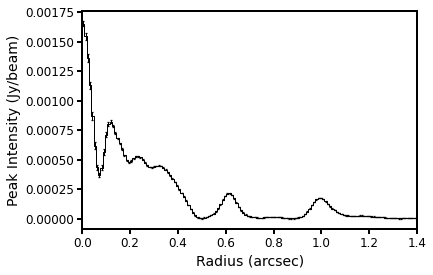

In [5]:
fig, ax = plt.subplots()
ax.errorbar(r_fish, I_fish, Ierr_fish, fmt=' ', capsize=1.25, capthick=1.25, color='k', lw=1.0)
ax.step(r_fish, I_fish, where='mid', color='k', lw=1.0)
ax.set_xlim(0, rout)
ax.set_xlabel('Radius (arcsec)')
ax.set_ylabel('Peak Intensity (Jy/beam)')

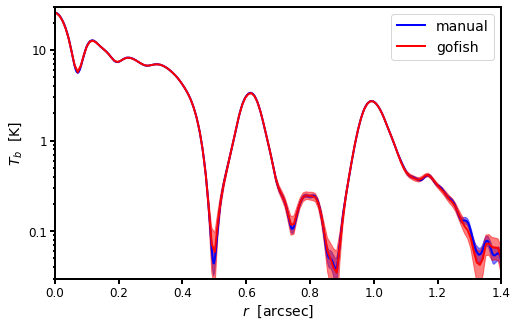

In [10]:
# compare gofish results with our manual calculation
# looks good, though we underestimated errors due to correlated pixels
fig, ax = plt.subplots(figsize=(8,5))

# read in the CLEAN map profile
r, Tb_manual, eTb_manual = np.loadtxt('AS209_radial_profile.txt').T
ax.fill_between(r, Tb_manual-eTb_manual, Tb_manual+eTb_manual, color='blue', alpha=0.5)
ax.plot(r, Tb_manual, 'b', lw=2, label='manual')

# convert radial profile from mJy/beam to brightness temperatures (R-J limit)
kB_, c_ = 1.38064852e-16, 2.99792e10
Tb_fish = c_**2 * 1e-23 * I_fish / beam_area / (2 * kB_ * freq**2)
eTb_fish = c_**2 * 1e-23 * Ierr_fish / beam_area / (2 * kB_ * freq**2)

ax.fill_between(r_fish, Tb_fish-eTb_fish, Tb_fish+eTb_fish, color='red', alpha=0.5)
ax.plot(r_fish, Tb_fish, 'r', lw=2, label='gofish')

ax.set_xlim([0, rout])
ax.set_ylim([0.03, 30])
ax.set_yscale('log')
ax.set_yticks([0.1, 1, 10])
ax.set_yticklabels(['0.1', '1', '10'])
ax.set_xlabel('$r \,\,$ [arcsec]')
ax.set_ylabel('$T_b \,\,$ [K]')
ax.legend()

In [12]:
fig.savefig('gofish_AS209.pdf')